In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import pandas as pd
import gc
import keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD

from skimage import measure
from skimage.morphology import square, erosion, dilation, watershed
import math

import kaggle_util

import cv2
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

Using TensorFlow backend.


In [2]:
TAR_SIZE = 384
INPUT_SHAPE = (TAR_SIZE, TAR_SIZE)

BATCH_SIZE = 4
PATH = './'
TRAIN = '../input/train_v2/'
TEST = '../input/test_v2/'
SEGMENTATION = '../input/train_ship_segmentations_v2.csv.zip'
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

In [3]:
masks = pd.read_csv(SEGMENTATION)
folds = pd.read_csv('../input/folds.csv')

In [4]:
# def prepare_train_set(folds, fold):
#     folds = folds.loc[folds.has_ship > 0]
#     train_fold = folds.loc[folds.fold != fold]
#     val_fold = folds.loc[(folds.fold == fold) & (folds.holdout == 1)]
    
    
#     return train_fold, val_fold


# fold = 0
# train_fold, val_fold = prepare_train_set(folds, fold)
# VALID_IMG_COUNT = len(val_fold)

In [5]:
fold = 0
folds = folds.loc[folds.has_ship > 0]
train_fold, val_fold = train_test_split(folds, test_size=0.05, random_state=42)
VALID_IMG_COUNT = len(val_fold)

In [6]:
print('train len:', len(train_fold), 'val len', len(val_fold))

train len: 40428 val len 2128


In [7]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[df.ImageId == img_id]['EncodedPixels']
    
#     print(img_id, masks)
    
    if(type(masks.iloc[0]) == float): return img.reshape(shape)
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [8]:
augments = [
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    Transpose(p=0.5),
    RandomBrightness(limit = 0.1, p = 0.2),
    RandomGamma(gamma_limit=(90, 110), p = 0.2),
]

In [9]:
def train_data_generator_sigmoid(val_df, masks, batch_size, input_shape, augments):
    
    while True:
        inputs = []
        outputs = []
        step_id = 0
        cnt = 0
        for idx, row in val_df.iterrows():
            img_id = row.ImageId
            imgpath = os.path.join(TRAIN, '{0}'.format(img_id))
            img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
            
            msk = get_mask(img_id, masks)
                
            img = cv2.resize(img, input_shape)
            msk = cv2.resize(msk, input_shape)
            
            for aug in augments:
                augmented = aug(image=img, mask=msk)
                img = augmented['image']
                msk = augmented['mask']
            
            msk = msk[..., np.newaxis]
            otp = msk
            
            inputs.append(img)
            outputs.append(otp)
         
            if len(inputs) == batch_size:
                step_id += 1
                inputs = np.asarray(inputs)
                outputs = np.asarray(outputs, dtype='float')
#                 for img in inputs:
#                     print(img.min(), img.max(), img.shape)
                yield inputs, outputs
                inputs = []
                outputs = []
    


In [10]:
def val_data_generator_sigmoid(val_df, masks, batch_size, validation_steps, input_shape):
    while True:
        inputs = []
        outputs = []
        step_id = 0
        for idx, row in val_df.iterrows():
            img_id = row.ImageId
            imgpath = os.path.join(TRAIN, '{0}'.format(img_id))

            img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
            msk = get_mask(img_id, masks)
            
            img = cv2.resize(img, input_shape)
            msk = cv2.resize(msk, input_shape)
            
            msk = msk[..., np.newaxis]
            otp = msk
            
            inputs.append(img)
            outputs.append(otp)
            
            if len(inputs) == batch_size:
                step_id += 1
                inputs = np.asarray(inputs)
                outputs = np.asarray(outputs, dtype='float')
                yield inputs, outputs
                inputs = []
                outputs = []
                if step_id == validation_steps:
                    break

In [11]:
val_steps = math.ceil(len(val_fold) / BATCH_SIZE)

In [12]:
train_gen = train_data_generator_sigmoid(train_fold, masks, BATCH_SIZE, INPUT_SHAPE, augments)
val_gen = val_data_generator_sigmoid(val_fold, masks, val_steps, val_steps, INPUT_SHAPE)

In [13]:
val_x, val_y = next(val_gen)

In [14]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [16]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1, fold = 0):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
        self.fold = fold

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./models/XUnet{}_{}.model".format(TAR_SIZE, self.fold),
                                      monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule),
            callbacks.TensorBoard(log_dir='./logs/XUnet{}_{}'.format(TAR_SIZE, self.fold)),
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

## Model

In [17]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [18]:
# https://github.com/titu1994/keras-normalized-optimizers
# Computes the L-2 norm of the gradient.
def l2_norm(grad):
    norm = K.sqrt(K.sum(K.square(grad))) + K.epsilon()
    return norm

class OptimizerWrapper(optimizers.Optimizer):

    def __init__(self, optimizer):     
        
        self.optimizer = optimizers.get(optimizer)

        # patch the `get_gradients` call
        self._optimizer_get_gradients = self.optimizer.get_gradients

    def get_gradients(self, loss, params):      
        grads = self._optimizer_get_gradients(loss, params)
        return grads

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        # monkey patch `get_gradients`
        self.optimizer.get_gradients = self.get_gradients

        # get the updates
        self.optimizer.get_updates(loss, params)

        # undo monkey patch
        self.optimizer.get_gradients = self._optimizer_get_gradients

        return self.updates

    def set_weights(self, weights):       
        self.optimizer.set_weights(weights)

    def get_weights(self):        
        return self.optimizer.get_weights()

    def get_config(self):       
        # properties of NormalizedOptimizer
        config = {'optimizer_name': self.optimizer.__class__.__name__.lower()}

        # optimizer config
        optimizer_config = {'optimizer_config': self.optimizer.get_config()}
        return dict(list(optimizer_config.items()) + list(config.items()))

    @property
    def weights(self):
        return self.optimizer.weights

    @property
    def updates(self):
        return self.optimizer.updates

    @classmethod
    def from_config(cls, config):
        raise NotImplementedError

    @classmethod
    def set_normalization_function(cls, name, func):
        global _NORMS
        _NORMS[name] = func

    @classmethod
    def get_normalization_functions(cls):        
        global _NORMS
        return sorted(list(_NORMS.keys()))


class NormalizedOptimizer(OptimizerWrapper):

    def __init__(self, optimizer, normalization='l2'):       
        super(NormalizedOptimizer, self).__init__(optimizer)

        if normalization not in _NORMS:
            raise ValueError('`normalization` must be one of %s.\n' 
                             'Provided was "%s".' % (str(sorted(list(_NORMS.keys()))), normalization))

        self.normalization = normalization
        self.normalization_fn = _NORMS[normalization]
        self.lr = K.variable(1e-3, name='lr')

    def get_gradients(self, loss, params):       
        grads = super(NormalizedOptimizer, self).get_gradients(loss, params)
        grads = [grad / self.normalization_fn(grad) for grad in grads]
        return grads

    def get_config(self):        
        # properties of NormalizedOptimizer
        config = {'normalization': self.normalization}

        # optimizer config
        base_config = super(NormalizedOptimizer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):       
        optimizer_config = {'class_name': config['optimizer_name'],
                            'config': config['optimizer_config']}

        optimizer = optimizers.get(optimizer_config)
        normalization = config['normalization']

        return cls(optimizer, normalization=normalization)


_NORMS = {
    'l2': l2_norm,
}

# register this optimizer to the global custom objects when it is imported
get_custom_objects().update({'NormalizedOptimizer': NormalizedOptimizer})

In [19]:
def UXception(input_shape=(None, None, 3)):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    # 10 -> 20
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.1)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    # 10 -> 20
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(0.1)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    # 20 -> 40
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    # 40 -> 80
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    
    # 80 -> 160
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(0.1/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [20]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [21]:
K.clear_session()
model = UXception(input_shape=(TAR_SIZE,TAR_SIZE,3))

In [22]:
sgd = SGD(0.005, momentum=0.9, nesterov=True)
sgd = NormalizedOptimizer(sgd, normalization='l2')

In [23]:
model.compile(loss=bce_dice_loss, optimizer=sgd, metrics=[my_iou_metric])

In [24]:
model.load_weights('./models/XUnet256_swa_0.model')

In [25]:
step_per_epoch = math.ceil(len(train_fold) / BATCH_SIZE / 3)

In [26]:
epochs = 30
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3, fold=fold)
swa = SWA('./models/XUnet{}_swa_{}.model'.format(TAR_SIZE, fold), 35)
history = model.fit_generator(train_gen, step_per_epoch,
                    validation_data = (val_x, val_y),
                    epochs=epochs,
                    workers = 3,
                    callbacks=snapshot.get_callbacks(),shuffle=True,verbose=1)

Stochastic weight averaging selected for last -5 epochs.
Epoch 1/30
3369/3369 [==============================] - 1216s 361ms/step - loss: 0.1632 - my_iou_metric: 0.4454 - val_loss: 0.1805 - val_my_iou_metric: 0.4291

Epoch 00001: val_my_iou_metric improved from -inf to 0.42914, saving model to ./models/XUnet384_0.model
Epoch 2/30
3369/3369 [==============================] - 1237s 367ms/step - loss: 0.1601 - my_iou_metric: 0.4459 - val_loss: 0.1703 - val_my_iou_metric: 0.4414

Epoch 00002: val_my_iou_metric improved from 0.42914 to 0.44135, saving model to ./models/XUnet384_0.model
Epoch 3/30
3369/3369 [==============================] - 1240s 368ms/step - loss: 0.1539 - my_iou_metric: 0.4498 - val_loss: 0.1814 - val_my_iou_metric: 0.4421

Epoch 00003: val_my_iou_metric improved from 0.44135 to 0.44211, saving model to ./models/XUnet384_0.model
Epoch 4/30
3369/3369 [==============================] - 1240s 368ms/step - loss: 0.1528 - my_iou_metric: 0.4556 - val_loss: 0.1774 - val_my_iou_m

KeyboardInterrupt: 

In [27]:
try:
    print('using swa weight model')
    model.load_weights('./models/XUnet{}_swa_{}.model'.format(TAR_SIZE, fold))
except:
    model.load_weights('./models/XUnet{}_{}.model'.format(TAR_SIZE, fold))

using swa weight model


In [28]:
def predict_result(model,x_test,img_size_target,batch_size): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test,batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect,batch_size=batch_size).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [29]:
oof_fold = folds.loc[folds.fold == fold]

In [30]:
oof_steps = math.ceil(len(oof_fold) / BATCH_SIZE)
oof_gen = val_data_generator_sigmoid(oof_fold, masks, oof_steps, oof_steps, INPUT_SHAPE)

In [31]:
oof_x, oof_y = next(oof_gen)

In [32]:
batch_size = 32
preds_test1 = model.predict(oof_x,batch_size=batch_size)
x_test_reflect =  np.array([np.fliplr(x) for x in oof_x])
preds_test2_refect = model.predict(x_test_reflect,batch_size=batch_size)
preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
preds_avg = (preds_test1 +preds_test2)/2
print(preds_avg.shape)

(2130, 384, 384, 1)


In [33]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [34]:
## Scoring for last model
thresholds = np.linspace(0.4, 0.6, 21)
ious = np.array([iou_metric_batch(oof_y, np.int32(preds_avg > threshold)) for threshold in tqdm_notebook(thresholds)])


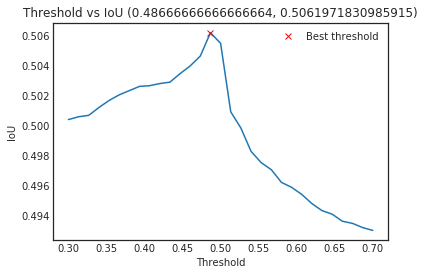

In [35]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [36]:
del oof_x, oof_y,preds_avg
gc.collect()

5

In [37]:
test_df = pd.read_csv('../input/sample_submission_v2.csv')

In [38]:
test_df.head()

,ImageId,EncodedPixels
0,00002bd58.jpg,1 2
1,00015efb6.jpg,1 2
2,00023d5fc.jpg,1 2
3,000367c13.jpg,1 2
4,0008ca6e9.jpg,1 2


In [39]:
batch_size = 32
preds_test = []

inputs = []
outputs = []
step_id = 0
for idx, row in test_df.iterrows():
    img_id = row.ImageId
    imgpath = os.path.join('../input/test_v2/', '{0}'.format(img_id))

    img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
    img = cv2.resize(img, INPUT_SHAPE)
    inputs.append(img)
inputs = np.asarray(inputs)
    

In [40]:
batch_size = 32
print('predict orignal test')
preds_test1 = model.predict(inputs,batch_size=batch_size)

print('predict flip left-right test')
x_test_reflect =  np.array([np.fliplr(x) for x in inputs])
preds_test2_refect = model.predict(x_test_reflect,batch_size=batch_size)
preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )

print('predict flip up-down')
x_test_ud =  np.array([np.flipud(x) for x in inputs])
preds_test3_refect = model.predict(x_test_ud,batch_size=batch_size)
preds_test3 = np.array([ np.flipud(x) for x in preds_test3_refect] )

preds_avg = (preds_test1 +preds_test2 + preds_test3) / 3

predict orignal test
predict flip left-right test
predict flip up-down


In [41]:
preds_avg.shape

(15606, 384, 384, 1)

In [42]:
preds_bool = (preds_avg > threshold_best ) * 1

In [43]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [44]:
preds_bool.shape

(15606, 384, 384, 1)

In [45]:
for i in tqdm_notebook(range(preds_bool.shape[0])):
    rle = ''
    if(preds_bool[i].max() > 0):
        #plt.imshow(preds_bool[i].squeeze())
        pre = preds_bool[i].astype(np.float).squeeze()
        ori_pred = ((cv2.resize(pre, (768,768)) > 0.5) * 1).astype(np.uint8)
        rle = rle_encode(ori_pred)

    test_df.iloc[i, 1] = rle

In [46]:
test_df.to_csv('../result/XUnet256_0.csv', index=False)
one_result = test_df

In [47]:
ship_detect = pd.read_csv('../result/ship_detection.csv')
ship_detect.rename({'id':'ImageId'}, axis = 1, inplace = True)
df_all = pd.merge(one_result, ship_detect, on='ImageId', how='left')
df_all.fillna('', inplace=True)

In [48]:
def split_mask(mask):
    threshold = 0.5
    threshold_obj = 0 #ignor predictions composed of "threshold_obj" pixels or less
    labled,n_objs = ndimage.label(mask)
    result = []
    for i in range(n_objs):
        obj = (labled == i + 1).astype(int)
        if(obj.sum() > threshold_obj): result.append(obj)
    return result

def decode_mask(mask, shape=(768, 768)):
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [49]:
one_result.fillna('', inplace=True)

In [50]:
from scipy import ndimage
def get_mask(encodepixel):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = encodepixel
    
#     print(img_id, masks)
    
    if(type(masks.iloc[0]) == float): return img.reshape(shape)
    for mask in masks:
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1
    return img.reshape(shape).T

In [51]:
new_result = pd.DataFrame(columns=one_result.columns)
cnt = 0
for idx, row in tqdm_notebook(one_result.iterrows()):
    if len(row.EncodedPixels) == 0:
        new_result = new_result.append(row, ignore_index=True)
    else:
        mask = get_mask(one_result.loc[one_result.ImageId == row.ImageId, 'EncodedPixels'])
        results = split_mask(mask)
        
        for msk in results:
            new_result = new_result.append({'ImageId':row.ImageId, 'EncodedPixels': decode_mask(msk)}, ignore_index=True)
#         cnt += 1
#         if cnt > 10:
#             break

In [53]:
kaggle_util.save_result(new_result, '../result/XUnet384_split.csv', competition = 'airbus-ship-detection', send = True, index = False)

save result
upload result
cmd: kaggle competitions submit -c airbus-ship-detection -f ../result/XUnet384_split.csv.7z -m "submit"
